In [ ]:
# The directory in Google drive that you want to save the results at
gdrive_dir = '/LG_Summer_School'

from google.colab import drive
drive.mount('/content/drive')

import os

if not os.path.exists('/content/drive/My Drive'+gdrive_dir):
    os.makedirs('/content/drive/My Drive'+gdrive_dir)
os.chdir('/content/drive/My Drive'+gdrive_dir)


datapath = ('/content/drive/My Drive'+gdrive_dir)

print(datapath)

if not os.path.exists('/content/drive/My Drive'+gdrive_dir+'/RSXFSN.csv'):
    !pip install pydrive
    print('\n\n')
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Downloading the data from Google drive link
    data_zip = drive.CreateFile({'id':'1VG_Ca7i2jBEWgVEtdUGxRW4kv93ctY5l'})
    data_zip.GetContentFile('RSXFSN.csv')

    print('\n ==> Succesfully downloaded and unzipped the data')

else:
    print('\n ==> Data have already been downloaded')

Mounted at /content/drive
/content/drive/My Drive/LG_Summer_School




 ==> Succesfully downloaded and unzipped the data


# 1.MLP timeseries forecasting

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/LG_Summer_School/RSXFSN.csv")

df.drop(labels='DATE',axis=1,inplace=True)
df

,RSXFSN
0,130683.0
1,131244.0
2,142488.0
3,147175.0
4,152420.0
...,...
373,529374.0
374,604084.0
375,588220.0
376,631059.0


In [ ]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
def get_timeseries(data, n_steps):
    x_ts, y_ts = [], []
    for ii in range(len(data) - n_steps):
        v = data.iloc[ii:(ii + n_steps)].values
        x_ts.append(v)
        w = data.iloc[ii + n_steps].values
        y_ts.append(w)
    return np.array(x_ts),np.array(y_ts)

#16개 단위의 샘플을 생성
n_steps = 16
X, y = get_timeseries(df.astype(float), n_steps)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#배치사이즈 설정
n_batch = 10
trainsets = TensorData(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=n_batch, shuffle=True)

testsets = TensorData(x_test, y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=n_batch, shuffle=False)

inferencesets = TensorData(X,y)
inferenceloader = torch.utils.data.DataLoader(inferencesets, batch_size=n_batch, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(n_steps, 50, bias=True) # 입력층(n_steps = 16) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.

        return x

In [ ]:
model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [ ]:
print(model)

MLP(
  (fc1): Linear(in_features=16, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
loss_ = [] # loss를 저장할 리스트.
n = len(trainloader)

for epoch in range(400):

  running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for _,(inputs,values) in enumerate(trainloader): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.

     # data에는 X, Y가 들어있다.

    inputs = inputs[:,:,0]
    values = values[:,0]
    optimizer.zero_grad() # 최적화 초기화.

    outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.

  loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


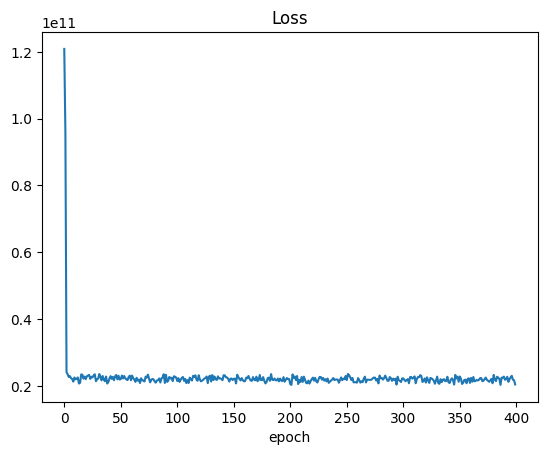

In [ ]:
plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
x_predict = []
y_label = []
for _,(inputs,values) in enumerate(inferenceloader): # 무작위로 섞인 n_batch개의 데이터가 담긴 배치가 하나씩 들어온다.

    inputs = inputs[:,:,0]
    values = values[:,0]

    outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    x_predict.append([t.item() for t in outputs])
    y_label.append([t.item() for t in values])

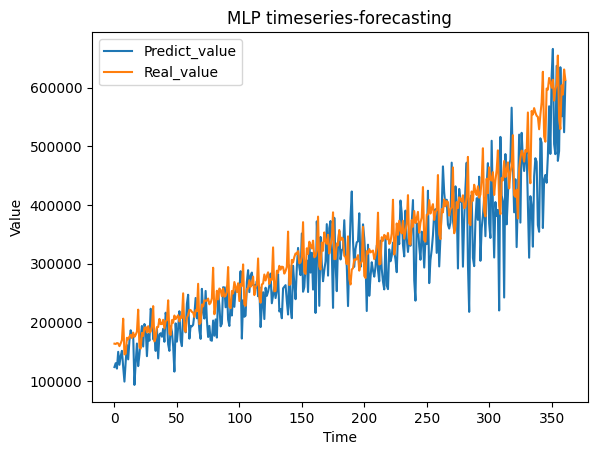

In [ ]:
x_predict_flat = [item for sublist in x_predict for item in sublist]
y_label_flat = [item for sublist in y_label for item in sublist]

plt.plot(x_predict_flat)
plt.plot(y_label_flat)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('MLP timeseries-forecasting')
plt.legend(['Predict_value', 'Real_value'])

In [ ]:
def evaluation(dataloader):

  predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

  with torch.no_grad():
    model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    for data in dataloader:
      inputs, values = data
      inputs = inputs[:,:,0]
      values = values[:,0]

      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
      actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

  predictions = predictions.numpy() # 넘파이 배열로 변경.
  actual = actual.numpy() # 넘파이 배열로 변경.
  rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해 RMSE를 계산.

  return rmse

In [ ]:
test_rmse = evaluation(testloader)

print(f'test rmse:{test_rmse}')

test rmse:49284.55078125
